## Regime Switching for Pairs Trading

When trading a spread between two correlated assets (like BTC and ETH), the key question is:
**when should I enter and exit positions?**

Fetching 17 days of 1h data for BTC and ETH...
Got 408 data points
Time range: 2025-01-15 01:00:00 to 2025-02-01 00:00:00


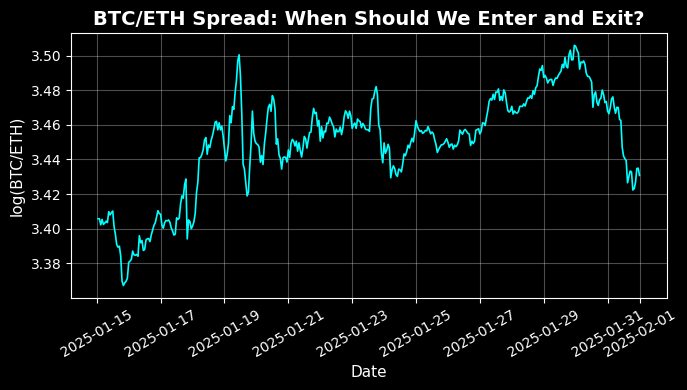

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from fetch_data import fetch_btc_eth_history
from datetime import datetime

# Fetch 17 days of hourly BTC/ETH data
plt.style.use("dark_background")
df = fetch_btc_eth_history(days=17, interval="1h", end_time=datetime(2025,2,1))

fig, ax = plt.subplots(figsize=(7, 4))
ax.plot(df["open_time"], df["log_ratio"], color="cyan", linewidth=1.2)
ax.set_xlabel("Date", fontsize=11)
ax.set_ylabel("log(BTC/ETH)", fontsize=11)
ax.set_title("BTC/ETH Spread: When Should We Enter and Exit?", fontsize=14, fontweight="bold")
ax.grid(True, alpha=0.3)
ax.tick_params(axis='x', rotation=30)
plt.tight_layout()
plt.show()


## Statistical Approach / Standard Deviations

Parameters estimated from first 14 days:
  Mean (μ): 3.4441
  Std dev (σ): 0.0281
  OU half-life: 33.6 hours


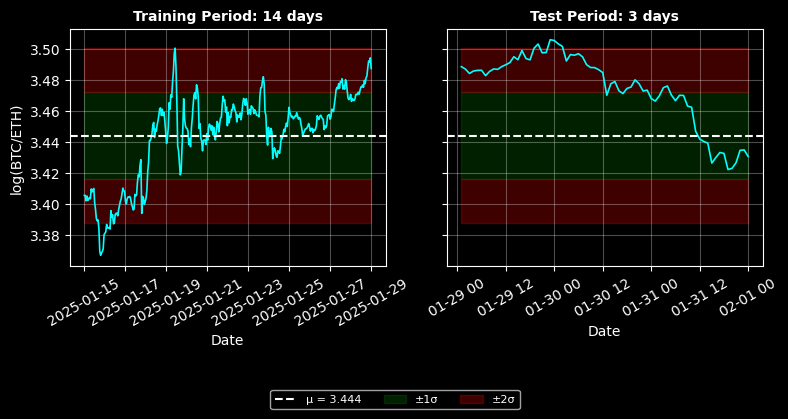

In [9]:
from fetch_data import estimate_ou_parameters

# Split into training (first 14 days) and test (last 3 days)
spread = df["log_ratio"].to_numpy()
times = df["open_time"]
dt = 1 / 24  # hourly data = 1/24 of a day

train_hours = 14 * 24
train_spread = spread[:train_hours]
train_times = times[:train_hours]
test_spread = spread[train_hours:]
test_times = times[train_hours:]

# Estimate parameters from training period only
params = estimate_ou_parameters(train_spread, dt)
mu = train_spread.mean()  # Use empirical mean
sigma = train_spread.std()  # Use empirical std dev (not OU sigma)

print(f"Parameters estimated from first 14 days:")
print(f"  Mean (μ): {mu:.4f}")
print(f"  Std dev (σ): {sigma:.4f}")
print(f"  OU half-life: {params['half_life']*24:.1f} hours")

# Visualize both periods
fig, axes = plt.subplots(1, 2, figsize=(8, 4), sharey=True)
lines = []

for idx, (ax, s, t, title) in enumerate([
    (axes[0], train_spread, train_times, "Training Period: 14 days"),
    (axes[1], test_spread, test_times, "Test Period: 3 days")
]):
    ax.plot(t, s, color="cyan", linewidth=1.2)
    l1 = ax.axhline(mu, color="white", linestyle="--", linewidth=1.5)
    l2 = ax.fill_between(t, mu - sigma, mu + sigma, color="green", alpha=0.25)
    l3 = ax.fill_between(t, mu - 2*sigma, mu - sigma, color="red", alpha=0.25)
    ax.fill_between(t, mu + sigma, mu + 2*sigma, color="red", alpha=0.25)
    ax.set_xlabel("Date", fontsize=10)
    ax.set_title(title, fontsize=10, fontweight="bold")
    ax.grid(True, alpha=0.3)
    ax.tick_params(axis='x', rotation=30)
    
    if idx == 0:
        lines = [l1, l2, l3]

axes[0].set_ylabel("log(BTC/ETH)", fontsize=10)

# Shared legend below
fig.legend(lines, [f'μ = {mu:.3f}', '±1σ', '±2σ'], 
           loc='lower center', ncol=3, fontsize=8, bbox_to_anchor=(0.5, -0.05))
plt.tight_layout(rect=[0, 0.08, 1, 1])
plt.show()


## Previous Best Result

Best threshold (overfit to training): 0.0146 (0.52σ)
Training PnL: 0.1717
Test PnL:     0.0463


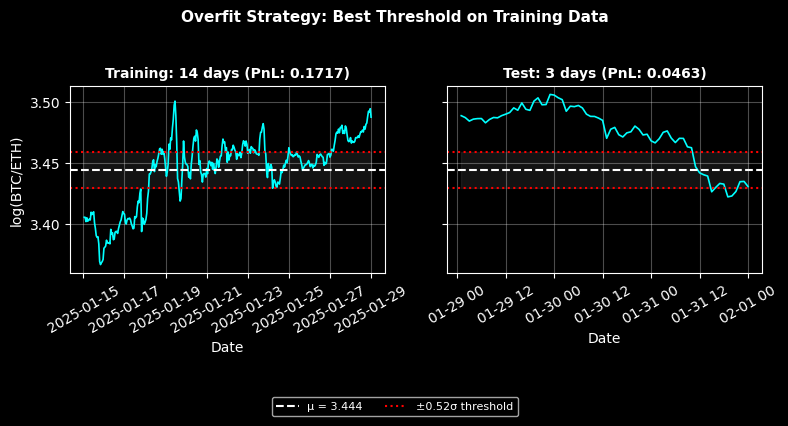

In [10]:
def backtest_threshold(spread: np.ndarray, mu: float, threshold: float, fee: float = 0.001) -> float:
    """
    Backtest a simple threshold strategy on spread data.
    
    Strategy:
    - Go long when spread < mu - threshold (expect reversion up)
    - Go short when spread > mu + threshold (expect reversion down)
    - Exit (go flat) when spread crosses mu
    
    Returns total PnL after fees.
    """
    position = 0  # -1 short, 0 flat, +1 long
    pnl = 0.0
    entry_price = 0.0
    
    for i in range(1, len(spread)):
        price = spread[i]
        prev_price = spread[i-1]
        
        # Check for exit first (cross the mean)
        if position == 1 and price >= mu:  # Long position, crossed above mean
            pnl += (price - entry_price) - fee
            position = 0
        elif position == -1 and price <= mu:  # Short position, crossed below mean
            pnl += (entry_price - price) - fee
            position = 0
        
        # Check for entry
        if position == 0:
            if price < mu - threshold:  # Enter long
                position = 1
                entry_price = price
                pnl -= fee
            elif price > mu + threshold:  # Enter short
                position = -1
                entry_price = price
                pnl -= fee
    
    # Close any open position at end
    if position == 1:
        pnl += (spread[-1] - entry_price)
    elif position == -1:
        pnl += (entry_price - spread[-1])
    
    return pnl

# Find the best threshold on training data (overfit!)
thresholds = np.linspace(0.001, 3 * sigma, 50)
train_pnls = [backtest_threshold(train_spread, mu, t) for t in thresholds]
best_idx = np.argmax(train_pnls)
best_threshold = thresholds[best_idx]
best_train_pnl = train_pnls[best_idx]

# Now test it out-of-sample
test_pnl = backtest_threshold(test_spread, mu, best_threshold)

print(f"Best threshold (overfit to training): {best_threshold:.4f} ({best_threshold/sigma:.2f}σ)")
print(f"Training PnL: {best_train_pnl:.4f}")
print(f"Test PnL:     {test_pnl:.4f}")

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(8, 4), sharey=True)
lines = []

for idx, (ax, s, t, title, pnl) in enumerate([
    (axes[0], train_spread, train_times, f"Training: 14 days (PnL: {best_train_pnl:.4f})", best_train_pnl),
    (axes[1], test_spread, test_times, f"Test: 3 days (PnL: {test_pnl:.4f})", test_pnl)
]):
    ax.plot(t, s, color="cyan", linewidth=1.2)
    l1 = ax.axhline(mu, color="white", linestyle="--", linewidth=1.5)
    l2 = ax.axhline(mu + best_threshold, color="red", linestyle=":", linewidth=1.5)
    ax.axhline(mu - best_threshold, color="red", linestyle=":", linewidth=1.5)
    ax.fill_between(t, mu - best_threshold, mu + best_threshold, color="gray", alpha=0.15)
    ax.set_xlabel("Date", fontsize=10)
    ax.set_title(title, fontsize=10, fontweight="bold")
    ax.grid(True, alpha=0.3)
    ax.tick_params(axis='x', rotation=30)
    
    if idx == 0:
        lines = [l1, l2]

axes[0].set_ylabel("log(BTC/ETH)", fontsize=10)

# Shared legend below
fig.legend(lines, [f'μ = {mu:.3f}', f'±{best_threshold/sigma:.2f}σ threshold'], 
           loc='lower center', ncol=2, fontsize=8, bbox_to_anchor=(0.5, -0.05))

plt.suptitle("Overfit Strategy: Best Threshold on Training Data", fontsize=11, fontweight="bold")
plt.tight_layout(rect=[0, 0.08, 1, 0.95])
plt.show()


## Reinforcement Learning
https://arxiv.org/abs/2512.04697v1

OU parameters from training data:
  θ (mean-reversion): 0.49 per day
  μ (long-term mean): 3.4441
  σ (OU volatility):  0.0282 per sqrt(day)
  Scale (empirical σ): 0.0281

Training on cuda...
Episode 100/200, Loss: -0.000000
Episode 200/200, Loss: -0.000000
Training complete!


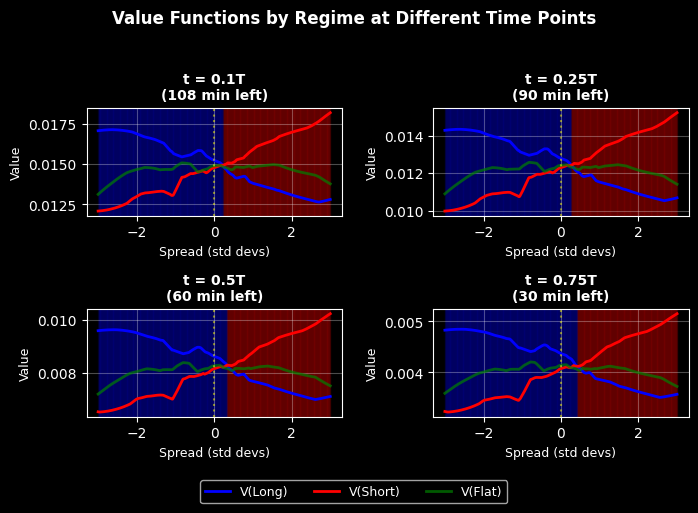

In [4]:
import torch
from pairs_trading import SWITCHING_COSTS, R_FUNDING, R_CASH
from regime_switching import Config, train

# Use OU parameters estimated from the ACTUAL training data
# (params, mu, sigma were computed in an earlier cell from train_spread)
THETA_REAL = params["theta"]  # Mean-reversion speed (per day)
MU_REAL = mu                   # Empirical mean of training spread
SIGMA_REAL = params["sigma"]   # OU volatility (per sqrt(day))
SPREAD_SCALE_REAL = sigma      # Use empirical std dev as scale

print(f"OU parameters from training data:")
print(f"  θ (mean-reversion): {THETA_REAL:.2f} per day")
print(f"  μ (long-term mean): {MU_REAL:.4f}")
print(f"  σ (OU volatility):  {SIGMA_REAL:.4f} per sqrt(day)")
print(f"  Scale (empirical σ): {SPREAD_SCALE_REAL:.4f}")
print()

# Define dynamics using REAL parameters
def dynamics_fn_real(t: torch.Tensor, x: torch.Tensor, i: torch.Tensor
                     ) -> tuple[torch.Tensor, torch.Tensor]:
    """OU dynamics using parameters estimated from actual training data."""
    drift = -THETA_REAL * x  # Mean-reverts to 0 (in normalized space)
    diffusion = torch.full_like(x, SIGMA_REAL / SPREAD_SCALE_REAL)
    return drift, diffusion

def running_reward_fn_real(t: torch.Tensor, x: torch.Tensor, i: torch.Tensor
                           ) -> torch.Tensor:
    """Running reward using real parameters."""
    drift_profit_long = -THETA_REAL * SPREAD_SCALE_REAL * x
    drift_profit_short = THETA_REAL * SPREAD_SCALE_REAL * x
    
    reward_long = drift_profit_long - R_FUNDING
    reward_short = drift_profit_short - R_FUNDING
    reward_flat = torch.full_like(x, R_CASH)
    
    return torch.where(i == 0, reward_long, 
                       torch.where(i == 1, reward_short, reward_flat))

def terminal_reward_real(x: torch.Tensor) -> torch.Tensor:
    """Terminal reward h = 0."""
    return torch.zeros(x.shape[0], device=x.device)

# Training config
config = Config(
    num_regimes=3, state_dim=1,
    switching_costs=SWITCHING_COSTS,
    temperature=0.1,
    T=2.0/24.0, K=120,  # 2 hours horizon, 1 step per minute
    batch_size=256, num_episodes=200,
    learning_rate=1e-3, hidden_dim=64,
    x0_mean=0.0,  # Normalized: 0 = at the mean
    x0_std=1.0,   # Normalized: 1 std = 1 unit
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Training on {device}...")

torch.manual_seed(42)
np.random.seed(42)
value_net, losses = train(config, terminal_reward_real, dynamics_fn_real, 
                          running_reward_fn_real, device)
print("Training complete!")

# Evaluate learned policy across spread values at MULTIPLE time points
value_net.eval()
spread_range = torch.linspace(-3.0, 3.0, 500, device=device)  # ±3 std devs
spread_np = spread_range.cpu().numpy()

# Time points to evaluate (as fractions of T)
time_fractions = [0.1, 0.25, 0.5, 0.75]
time_labels = ['t = 0.1T\n(108 min left)', 't = 0.25T\n(90 min left)', 
               't = 0.5T\n(60 min left)', 't = 0.75T\n(30 min left)']

fig, axes = plt.subplots(2, 2, figsize=(7, 5))
axes = axes.flatten()

# Store values at t=0.5T for threshold calculation later
v_long, v_short, v_flat = None, None, None
lines = []  # Store line handles for shared legend

for idx, (t_frac, t_label) in enumerate(zip(time_fractions, time_labels)):
    ax = axes[idx]
    t_val = t_frac * config.T
    t_tensor = torch.full_like(spread_range, t_val)
    
    with torch.no_grad():
        values = value_net(t_tensor, spread_range)
        v_l = values[:, 0].cpu().numpy()
        v_s = values[:, 1].cpu().numpy()
        v_f = values[:, 2].cpu().numpy()
    
    # Store t=0.5T values for later use
    if t_frac == 0.5:
        v_long, v_short, v_flat = v_l, v_s, v_f
    
    l1, = ax.plot(spread_np, v_l, 'b-', label='V(Long)', linewidth=2)
    l2, = ax.plot(spread_np, v_s, 'r-', label='V(Short)', linewidth=2)
    l3, = ax.plot(spread_np, v_f, 'g-', label='V(Flat)', linewidth=2, alpha=0.7)
    
    if idx == 0:
        lines = [l1, l2, l3]
    
    # Shade optimal regions
    optimal_regime = np.argmax([v_l, v_s, v_f], axis=0)
    colors = ['blue', 'red', 'green']
    for i in range(len(spread_np) - 1):
        ax.axvspan(spread_np[i], spread_np[i+1], alpha=0.1, color=colors[optimal_regime[i]])
    
    ax.axvline(x=0, color='yellow', linestyle=':', alpha=0.5)
    ax.set_xlabel('Spread (std devs)', fontsize=9)
    ax.set_ylabel('Value', fontsize=9)
    ax.set_title(t_label, fontsize=10, fontweight='bold')
    ax.grid(True, alpha=0.3)

# Shared legend below the plots
fig.legend(lines, ['V(Long)', 'V(Short)', 'V(Flat)'], loc='lower center', 
           ncol=3, fontsize=9, bbox_to_anchor=(0.5, -0.02))
plt.suptitle('Value Functions by Regime at Different Time Points', fontsize=12, fontweight='bold')
plt.tight_layout(rect=[0, 0.05, 1, 0.95])
plt.show()

# Calculate switching thresholds (using t=0.5T values)
cost_matrix = np.array(SWITCHING_COSTS)
switching_thresholds = {}

diff_short_to_long = v_long - v_short
cost_short_to_long = cost_matrix[1, 0]
switch_short_to_long_idx = np.where(diff_short_to_long > cost_short_to_long)[0]
if len(switch_short_to_long_idx) > 0:
    switching_thresholds['Short→Long'] = spread_np[switch_short_to_long_idx[-1]]

diff_long_to_short = v_short - v_long
cost_long_to_short = cost_matrix[0, 1]
switch_long_to_short_idx = np.where(diff_long_to_short > cost_long_to_short)[0]
if len(switch_long_to_short_idx) > 0:
    switching_thresholds['Long→Short'] = spread_np[switch_long_to_short_idx[0]]


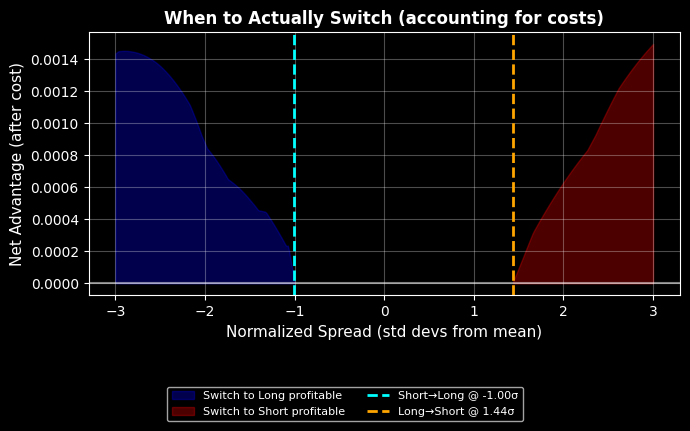


LEARNED SWITCHING RULES (trained on actual data parameters)

Thresholds in normalized units (std devs from training mean):
  Short→Long threshold: -1.00σ
  Long→Short threshold: 1.44σ
  Hysteresis gap: 2.44σ

In raw spread values:
  Switch to LONG when spread < 3.4159
  Switch to SHORT when spread > 3.4845


In [6]:
# Visualize when switching is profitable (accounting for costs)
fig, ax = plt.subplots(figsize=(7, 4))

advantage_to_long = v_long - v_short - cost_short_to_long
advantage_to_short = v_short - v_long - cost_long_to_short

l1 = ax.fill_between(spread_np, 0, advantage_to_long, where=advantage_to_long > 0, 
                     alpha=0.3, color='blue', label='Switch to Long profitable')
l2 = ax.fill_between(spread_np, 0, advantage_to_short, where=advantage_to_short > 0,
                     alpha=0.3, color='red', label='Switch to Short profitable')
ax.axhline(0, color='white', linestyle='-', alpha=0.5)

if 'Short→Long' in switching_thresholds:
    x = switching_thresholds['Short→Long']
    l3 = ax.axvline(x=x, color='cyan', linestyle='--', linewidth=2)
if 'Long→Short' in switching_thresholds:
    x = switching_thresholds['Long→Short']
    l4 = ax.axvline(x=x, color='orange', linestyle='--', linewidth=2)

ax.set_xlabel('Normalized Spread (std devs from mean)', fontsize=11)
ax.set_ylabel('Net Advantage (after cost)', fontsize=11)
ax.set_title('When to Actually Switch (accounting for costs)', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3)

# Legend at bottom
fig.legend([l1, l2, l3, l4], 
           ['Switch to Long profitable', 'Switch to Short profitable',
            f'Short→Long @ {switching_thresholds["Short→Long"]:.2f}σ', 
            f'Long→Short @ {switching_thresholds["Long→Short"]:.2f}σ'],
           loc='lower center', ncol=2, fontsize=8, bbox_to_anchor=(0.5, -0.08))
plt.tight_layout(rect=[0, 0.1, 1, 1])
plt.show()

# Print trading rules
print("\n" + "="*70)
print("LEARNED SWITCHING RULES (trained on actual data parameters)")
print("="*70)
print(f"\nThresholds in normalized units (std devs from training mean):")

if 'Short→Long' in switching_thresholds and 'Long→Short' in switching_thresholds:
    x_s2l = switching_thresholds['Short→Long']
    x_l2s = switching_thresholds['Long→Short']
    
    print(f"  Short→Long threshold: {x_s2l:.2f}σ")
    print(f"  Long→Short threshold: {x_l2s:.2f}σ")
    print(f"  Hysteresis gap: {x_l2s - x_s2l:.2f}σ")
    print()
    
    # Convert to raw values
    raw_s2l = x_s2l * SPREAD_SCALE_REAL + MU_REAL
    raw_l2s = x_l2s * SPREAD_SCALE_REAL + MU_REAL
    
    print(f"In raw spread values:")
    print(f"  Switch to LONG when spread < {raw_s2l:.4f}")
    print(f"  Switch to SHORT when spread > {raw_l2s:.4f}")
else:
    print("Could not find clear switching thresholds")


## Extract thresholds from trained model and backtest

RL Learned Thresholds (with hysteresis):
  Switch to Long when spread < 3.4159 (-1.00σ)
  Switch to Short when spread > 3.4845 (1.44σ)
  Hysteresis gap: 0.0686

Training PnL (RL): 0.0750
Test PnL (RL):     0.0568

Comparison to naive overfit strategy:
  Naive Training PnL: 0.1717
  Naive Test PnL:     0.0463


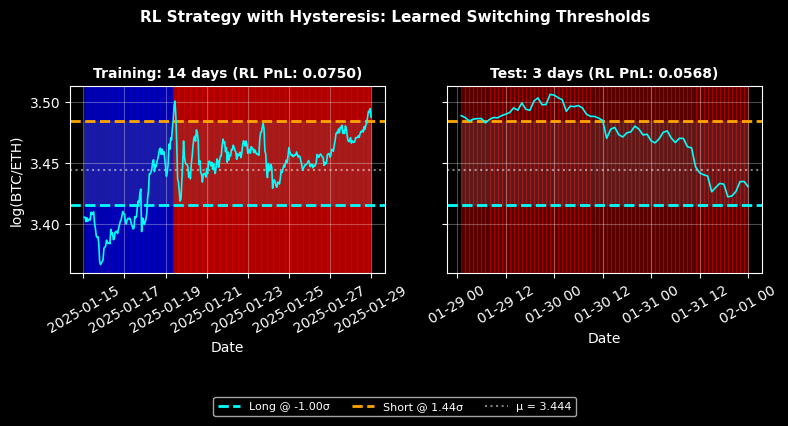


STRATEGY COMPARISON
Strategy                     Train PnL     Test PnL
--------------------------------------------------
Naive (overfit σ)               0.1717       0.0463
RL (hysteresis)                 0.0750       0.0568


In [11]:
# Apply learned thresholds to real data with HYSTERESIS
# Convert thresholds from normalized (std devs) to raw spread values
threshold_short_to_long_raw = switching_thresholds['Short→Long'] * SPREAD_SCALE_REAL + MU_REAL
threshold_long_to_short_raw = switching_thresholds['Long→Short'] * SPREAD_SCALE_REAL + MU_REAL

def backtest_hysteresis(spread: np.ndarray, thresh_s2l: float, thresh_l2s: float, 
                        fee: float = 0.001) -> tuple[float, list]:
    """
    Backtest with hysteresis: different thresholds for entering Long vs Short.
    
    - If Short: switch to Long when spread < thresh_s2l
    - If Long: switch to Short when spread > thresh_l2s
    - Start Flat, enter Long below thresh_s2l, enter Short above thresh_l2s
    
    Returns (total_pnl, position_history)
    """
    position = 0  # -1 short, 0 flat, +1 long
    pnl = 0.0
    entry_price = 0.0
    positions = []
    
    for i in range(len(spread)):
        price = spread[i]
        
        if position == 0:  # Flat - look for entry
            if price < thresh_s2l:
                position = 1  # Go long
                entry_price = price
                pnl -= fee
            elif price > thresh_l2s:
                position = -1  # Go short
                entry_price = price
                pnl -= fee
        elif position == 1:  # Long - check for switch to short
            if price > thresh_l2s:
                # Close long and open short
                pnl += (price - entry_price) - fee
                position = -1
                entry_price = price
                pnl -= fee
        elif position == -1:  # Short - check for switch to long
            if price < thresh_s2l:
                # Close short and open long
                pnl += (entry_price - price) - fee
                position = 1
                entry_price = price
                pnl -= fee
        
        positions.append(position)
    
    # Close any open position at end
    if position == 1:
        pnl += (spread[-1] - entry_price)
    elif position == -1:
        pnl += (entry_price - spread[-1])
    
    return pnl, positions

# Run backtest on both periods
train_pnl_rl, train_positions = backtest_hysteresis(train_spread, threshold_short_to_long_raw, 
                                                     threshold_long_to_short_raw)
test_pnl_rl, test_positions = backtest_hysteresis(test_spread, threshold_short_to_long_raw,
                                                   threshold_long_to_short_raw)

print(f"RL Learned Thresholds (with hysteresis):")
print(f"  Switch to Long when spread < {threshold_short_to_long_raw:.4f} ({switching_thresholds['Short→Long']:.2f}σ)")
print(f"  Switch to Short when spread > {threshold_long_to_short_raw:.4f} ({switching_thresholds['Long→Short']:.2f}σ)")
print(f"  Hysteresis gap: {threshold_long_to_short_raw - threshold_short_to_long_raw:.4f}")
print()
print(f"Training PnL (RL): {train_pnl_rl:.4f}")
print(f"Test PnL (RL):     {test_pnl_rl:.4f}")

# Compare to naive strategy
print(f"\nComparison to naive overfit strategy:")
print(f"  Naive Training PnL: {best_train_pnl:.4f}")
print(f"  Naive Test PnL:     {test_pnl:.4f}")

# Visualize with position coloring
fig, axes = plt.subplots(1, 2, figsize=(8, 4), sharey=True)
lines = []

for idx, (ax, s, t, pos, title) in enumerate([
    (axes[0], train_spread, train_times, train_positions, 
     f"Training: 14 days (RL PnL: {train_pnl_rl:.4f})"),
    (axes[1], test_spread, test_times, test_positions,
     f"Test: 3 days (RL PnL: {test_pnl_rl:.4f})")
]):
    # Plot spread
    ax.plot(t, s, color="cyan", linewidth=1.2, zorder=3)
    
    # Shade by position
    pos_arr = np.array(pos)
    t_arr = np.array(t)
    for i in range(len(s) - 1):
        if pos_arr[i] == 1:  # Long
            ax.axvspan(t_arr[i], t_arr[i+1], alpha=0.3, color='blue')
        elif pos_arr[i] == -1:  # Short
            ax.axvspan(t_arr[i], t_arr[i+1], alpha=0.3, color='red')
    
    # Draw thresholds
    l1 = ax.axhline(threshold_short_to_long_raw, color='cyan', linestyle='--', linewidth=2)
    l2 = ax.axhline(threshold_long_to_short_raw, color='orange', linestyle='--', linewidth=2)
    l3 = ax.axhline(MU_REAL, color='white', linestyle=':', alpha=0.5)
    l4 = ax.fill_between(t, threshold_short_to_long_raw, threshold_long_to_short_raw, 
                         color='gray', alpha=0.2)
    
    if idx == 0:
        lines = [l1, l2, l3]
    
    ax.set_xlabel("Date", fontsize=10)
    ax.set_title(title, fontsize=10, fontweight="bold")
    ax.grid(True, alpha=0.3)
    ax.tick_params(axis='x', rotation=30)

axes[0].set_ylabel("log(BTC/ETH)", fontsize=10)

# Shared legend below
fig.legend(lines, [f'Long @ {switching_thresholds["Short→Long"]:.2f}σ', 
                   f'Short @ {switching_thresholds["Long→Short"]:.2f}σ',
                   f'μ = {MU_REAL:.3f}'], 
           loc='lower center', ncol=3, fontsize=8, bbox_to_anchor=(0.5, -0.05))

plt.suptitle("RL Strategy with Hysteresis: Learned Switching Thresholds", 
             fontsize=11, fontweight="bold")
plt.tight_layout(rect=[0, 0.08, 1, 0.95])
plt.show()

# Summary comparison
print("\n" + "="*50)
print("STRATEGY COMPARISON")
print("="*50)
print(f"{'Strategy':<25} {'Train PnL':>12} {'Test PnL':>12}")
print("-"*50)
print(f"{'Naive (overfit σ)':<25} {best_train_pnl:>12.4f} {test_pnl:>12.4f}")
print(f"{'RL (hysteresis)':<25} {train_pnl_rl:>12.4f} {test_pnl_rl:>12.4f}")


## How Does This Work?

### Step 1: Model the spread as a statistical process

We assume the spread follows an **Ornstein-Uhlenbeck (OU) process**:

$$dS = \theta(\mu - S)dt + \sigma dW$$

In plain English:
- **S** = current spread value
- **θ(μ - S)** = "pull toward the mean" — if S is above μ, this is negative (pulls down); if S is below μ, this is positive (pulls up)
- **θ** = how strong the pull is (higher = faster mean-reversion)
- **σdW** = random noise (Brownian motion)

This is just a fancy way of saying: **"the spread tends to revert to its mean, plus some randomness"**

We estimate θ, μ, and σ from the training data using linear regression on the changes in spread.

### Step 2-4: The RL Pipeline

2. **Simulate many paths** — Using the fitted OU model, generate thousands of synthetic trajectories

3. **Learn the value function** — A neural network learns V(x, regime) = "expected future reward starting from spread x in this regime"

4. **Extract thresholds** — Query where V(Long) > V(Short) + switching_cost to find optimal switching points

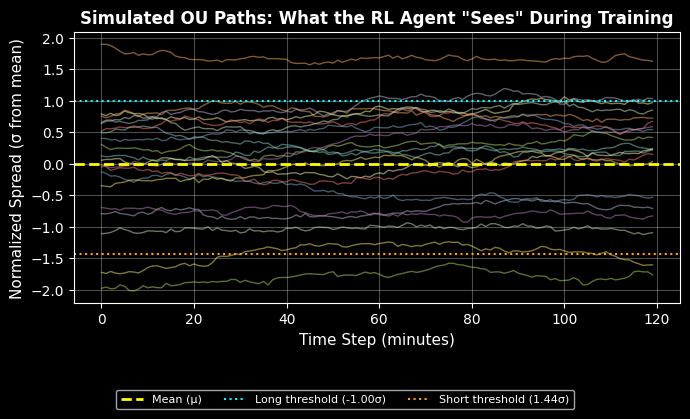

Each path: 120 steps over 120 minutes
The agent learns which regime (Long/Short/Flat) maximizes reward across all these scenarios


In [7]:
# Step 2: What does "simulate many paths" look like?
# Here are 20 sample trajectories the RL agent might see during training

def simulate_ou_path(x0: float, theta: float, sigma: float, dt: float, n_steps: int) -> np.ndarray:
    """Simulate a single OU path (in normalized space where mean=0)."""
    path = np.zeros(n_steps)
    path[0] = x0
    for i in range(1, n_steps):
        drift = -theta * path[i-1] * dt
        diffusion = sigma * np.sqrt(dt) * np.random.randn()
        path[i] = path[i-1] + drift + diffusion
    return path

# Simulation parameters (matching training config)
n_paths = 20
n_steps = 120  # 2 hours at 1 step/min
dt_sim = (2.0/24.0) / n_steps  # Time step in days

# Use the OU parameters we estimated from real data
theta_sim = THETA_REAL
sigma_sim = SIGMA_REAL / SPREAD_SCALE_REAL  # Normalized volatility

fig, ax = plt.subplots(figsize=(7, 4))

# Simulate paths starting from different points
np.random.seed(42)
for _ in range(n_paths):
    x0 = np.random.randn() * 1.0  # Start from random point ~N(0,1)
    path = simulate_ou_path(x0, theta_sim, sigma_sim, dt_sim, n_steps)
    ax.plot(path, alpha=0.5, linewidth=1)

l1 = ax.axhline(0, color='yellow', linestyle='--', linewidth=2)
l2 = ax.axhline(-switching_thresholds['Short→Long'], color='cyan', linestyle=':')
l3 = ax.axhline(-switching_thresholds['Long→Short'], color='orange', linestyle=':')

ax.set_xlabel('Time Step (minutes)', fontsize=11)
ax.set_ylabel('Normalized Spread (σ from mean)', fontsize=11)
ax.set_title('Simulated OU Paths: What the RL Agent "Sees" During Training', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3)

# Legend at bottom
fig.legend([l1, l2, l3], 
           ['Mean (μ)', f'Long threshold ({switching_thresholds["Short→Long"]:.2f}σ)',
            f'Short threshold ({switching_thresholds["Long→Short"]:.2f}σ)'],
           loc='lower center', ncol=3, fontsize=8, bbox_to_anchor=(0.5, -0.05))
plt.tight_layout(rect=[0, 0.08, 1, 1])
plt.show()

print(f"Each path: {n_steps} steps over {config.T*24*60:.0f} minutes")
print(f"The agent learns which regime (Long/Short/Flat) maximizes reward across all these scenarios")


## The Value Function: What Is It?

**V(x, regime, t)** answers the question: *"If I'm at spread x, time t in this regime, what's my expected total future profit?"*

It's a neural network that takes three inputs:
- **x** = current spread (normalized)
- **regime** = current position (Long, Short, or Flat)
- **t** = time

And outputs a single number: the expected cumulative reward from now until the end of the horizon.

### How Is It Trained?

The paper uses **policy iteration** with a clever trick called the **martingale loss**:

1. Simulate a batch of OU paths
2. Along each path, the value function should satisfy a consistency equation — roughly: *"V(now) = immediate reward + discounted V(next)"*
3. Any violation of this equation is a training error
4. Minimize these errors with gradient descent

The key insight: we don't need to know the optimal policy in advance. The value function and optimal policy are learned together — once V is accurate, the optimal action is just "pick the regime with highest V (minus switching cost)".

### Why Three Curves?

We learn a separate value for each regime:
- **V(Long)** = expected profit if currently Long
- **V(Short)** = expected profit if currently Short  
- **V(Flat)** = expected profit if currently Flat

Where V(Long) > V(Short), being Long is more valuable. The **switching cost** creates hysteresis — we don't flip at x=0, we wait until the benefit exceeds the cost of switching.